# Improving Flu Vaccination Rates with a Targeted Outreach Program

Lovelace Health, a Federally Qualified Health Center, wishes to increase the proportion of its patients who receive the flu vaccine.  The Health Center plans to reach out to individual patients by phone to encourage them to schedule their vaccine appointments.

In addition to targeting those most at risk of complications from the flu, the health center hopes to reach out to those who are least likely to get the vaccine, in order to boost immunity in its patient population generally.

My task is to build a model that can use the patient health and demographic data Lovelace already has on file to predict which patients are unlikely to get the vaccine.

## Data Understanding

To build the model, I used data from the [National 2009 H1N1 Flu Survey](https://www.cdc.gov/nchs/nis/data_files_h1n1.htm), a government-sponsored telephone survey designed to monitor vaccination rates for both flu and H1N1 during the 2009-10 season. Specifically, I used the data as curated by DrivenData for its [Flu Shot Learning](https://www.drivendata.org/competitions/66/flu-shot-learning/) competition.

For this problem, I used only data that a community health center would store in its electronic health record, although the survey results also contained information about health-related opinions and behaviors.  Additionally, although the results show whether each respondent received both the flu and H1N1 vaccines, for this exercise I focused on predicting only flu vaccine status.

The data contain over 20,000 survey responses from Americans aged 18 and over, and show that about 47% of respondents received the flu vaccine.  The data include variables showing each respondent's age, sex, race, marital status, geographic location, health insurance status, and occupation.  They also show whether the respondent had a chronic health condition and whether their doctor recommended the flu vaccine. Several columns have a small amount of null values, and about half the values are null in the occupation and insurance status columns.

Demographic categories in the data are not quite representative of the U.S. population at the time.  For example, 59% of respondents were women, and the age of respondents was skewed toward older demographics.  Additionally, 79% of survey respondents were white while only 72% of the population identified as white on the 2010 census.  Only 8% and 7% of survey respondents identified as black and Hispanic respectively; in contrast the [2010 census](https://www.census.gov/newsroom/releases/archives/2010_census/cb11-cn125.html) proportions were 13% and 16%.  The large discrepancy in the proportions of people identifying as Hispanic is partly explained by the fact that the census treated Hispanic/non-Hispanic as an ethnicity and not a race, while the survey did not.  These discrepancies imply we should be skeptical of drawing conclusions based on race.

Finally, in order to protect the identities of respondents, the names of geographic regions and occupations have all been scrambled.  This is also the reason why races other than white, black, and Hispanic have been lumped into the 'Other or Multiple' category - these groups are so small that separating them might compromise respondent privacy.

## Data Preparation

In [1]:
# import packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import utils as ut

In [2]:
# import predictors (data) and target (labels)

data = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [3]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3.00000,1.00000,2.00000,2.00000,1.00000,2.00000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00000,0.00000,NaN,NaN
1,1,3.00000,2.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,5.00000,4.00000,4.00000,4.00000,2.00000,4.00000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00000,0.00000,pxcmvdjn,xgwztkwe
2,2,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,1.00000,0.00000,0.00000,nan,3.00000,1.00000,1.00000,4.00000,1.00000,2.00000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00000,0.00000,rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,nan,3.00000,3.00000,5.00000,5.00000,4.00000,1.00000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00000,0.00000,NaN,NaN
4,4,2.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,3.00000,3.00000,2.00000,3.00000,1.00000,4.00000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00000,0.00000,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,3.00000,1.00000,1.00000,5.00000,2.00000,2.00000,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00000,0.00000,NaN,NaN
26703,26703,1.00000,2.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,4.00000,2.00000,2.00000,5.00000,1.00000,1.00000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00000,0.00000,fcxhlnwr,cmhcxjea
26704,26704,2.00000,2.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,4.00000,4.00000,2.00000,5.00000,4.00000,2.00000,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00000,0.00000,NaN,NaN
26705,26705,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,1.00000,2.00000,2.00000,1.00000,2.00000,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.00000,0.00000,fcxhlnwr,haliazsg


In [4]:
labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


**Define Predictors and Target**

In [5]:
# define X (predictors) and y (target)
# keep only predictors which a health center would have on file
# use seasonal flu vaccine outcome as target (disregard H1N1)

X = data.drop(columns=['h1n1_concern',
                       'h1n1_knowledge',
                       'behavioral_antiviral_meds',
                       'behavioral_avoidance',
                       'behavioral_face_mask',
                       'behavioral_wash_hands',
                       'behavioral_large_gatherings',
                       'behavioral_outside_home',
                       'behavioral_touch_face',
                       'doctor_recc_h1n1',
                       'child_under_6_months',
                       'opinion_h1n1_vacc_effective',
                       'opinion_h1n1_risk',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective',
                       'opinion_seas_risk',
                       'opinion_seas_sick_from_vacc',
                       'education',
                       'income_poverty',
                       'rent_or_own',
                       'household_adults',
                       'household_children'])

y = labels['seasonal_vaccine']

In [6]:
X

,respondent_id,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


**Column descriptions from DrivenData:**

* respondent_id - a unique and random identifier
* doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
* doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
* chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
* health_worker - Is a healthcare worker. (binary)
* health_insurance - Has health insurance. (binary)
* age_group - Age group of respondent.
* race - Race of respondent.
* sex - Sex of respondent.
* marital_status - Marital status of respondent.
* employment_status - Employment status of respondent.
* hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
* census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
* employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
* employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [7]:
# eliminate id column, which is the same as index number

X.drop(columns='respondent_id', inplace=True)
X

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


**Train-Test Split**

In [8]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Data Exploration**

In [9]:
# no class imbalance in target

y_train.value_counts()
# y_train.describe()  # mean is 0.46

0    10689
1     9341
Name: seasonal_vaccine, dtype: int64

In [10]:
# explore variables

X_train
X_train.describe()
X_train.info()

# many nulls
# many categorical columns --> need to encode

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 10602 to 22295
Data columns (total 13 columns):
doctor_recc_seasonal     18401 non-null float64
chronic_med_condition    19274 non-null float64
health_worker            19417 non-null float64
health_insurance         10836 non-null float64
age_group                20030 non-null object
race                     20030 non-null object
sex                      20030 non-null object
marital_status           18970 non-null object
employment_status        18930 non-null object
hhs_geo_region           20030 non-null object
census_msa               20030 non-null object
employment_industry      9996 non-null object
employment_occupation    9883 non-null object
dtypes: float64(4), object(9)
memory usage: 2.1+ MB


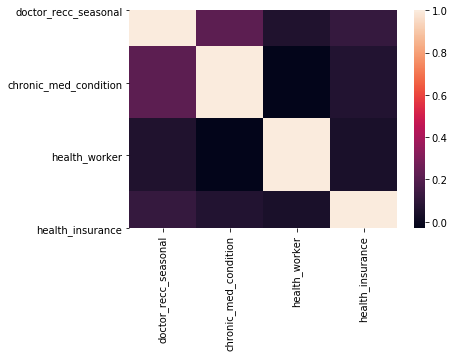

In [11]:
# heatmap shows few correlations due to high number of nulls and categorical columns

corr = X_train.corr()
sns.heatmap(corr)

In [12]:
# explore 'race' proportions for comparison to 2010 census data

X_train['race'].value_counts()/len(X_train)

# race proportions are different from 2010 census data - see Data Understanding above

White               0.79126
Black               0.08113
Hispanic            0.06750
Other or Multiple   0.06011
Name: race, dtype: float64

In [13]:
# show per cent nulls by column
# about half of data is missing for health_insurance, employment_industry, employment_occupation

round((X_train.isna().sum()*100/len(X_train)),2)

doctor_recc_seasonal     8.13000
chronic_med_condition    3.77000
health_worker            3.06000
health_insurance        45.90000
age_group                0.00000
race                     0.00000
sex                      0.00000
marital_status           5.29000
employment_status        5.49000
hhs_geo_region           0.00000
census_msa               0.00000
employment_industry     50.09000
employment_occupation   50.66000
dtype: float64

In [14]:
# look at value counts - see if there is an obvious choice to impute for nulls
# see if there are any very small categories - looks like some employment categories are very small

for c in X_train.columns:
    print(X_train[c].value_counts())
    
# most ppl have health insurance, I can create a new column to indicate which rows are missing this info
# employment industry and occupation - when encoded, nulls will be ignored

0.00000    12348
1.00000     6053
Name: doctor_recc_seasonal, dtype: int64
0.00000    13792
1.00000     5482
Name: chronic_med_condition, dtype: int64
0.00000    17271
1.00000     2146
Name: health_worker, dtype: int64
1.00000    9528
0.00000    1308
Name: health_insurance, dtype: int64
65+ Years        5183
55 - 64 Years    4130
18 - 34 Years    3929
45 - 54 Years    3884
35 - 44 Years    2904
Name: age_group, dtype: int64
White                15849
Black                 1625
Hispanic              1352
Other or Multiple     1204
Name: race, dtype: int64
Female    11873
Male       8157
Name: sex, dtype: int64
Married        10154
Not Married     8816
Name: marital_status, dtype: int64
Employed              10137
Not in Labor Force     7689
Unemployed             1104
Name: employment_status, dtype: int64
lzgpxyit    3227
fpwskwrf    2484
qufhixun    2297
bhuqouqj    2162
kbazzjca    2149
oxchjgsf    2141
mlyzmhmf    1684
lrircsnp    1529
atmpeygn    1508
dqpwygqj     849
Name: hhs_geo_

In [21]:
# create bar graphs to explore interactions between variables
# create new df X_train_plot to contain a numeric age column for plotting

X_train_plot=X_train.copy()
X_train_plot['age_group_num'] = X_train_plot['age_group'].apply(lambda x: 1 if (x == '18 - 34 Years')
                                                        else 2 if (x == '35 - 44 Years')
                                                        else 3 if (x == '45 - 54 Years')
                                                        else 4 if (x == '55 - 64 Years')
                                                        else 5)

In [22]:
# concatenate X_train_plot and y_train to create a df for plotting bar graphs

train_to_plot = pd.concat([X_train_plot, y_train], axis=1).drop(columns='age_group')
train_to_plot

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group_num,seasonal_vaccine
10602,0.00000,0.00000,1.00000,nan,White,Female,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,kldqjyjy,1,1
22208,0.00000,0.00000,0.00000,1.00000,White,Female,Married,Employed,bhuqouqj,"MSA, Not Principle City",ldnlellj,mxkfnird,5,0
7503,0.00000,0.00000,0.00000,0.00000,Black,Female,Married,Unemployed,lzgpxyit,"MSA, Principle City",NaN,NaN,1,0
6140,1.00000,0.00000,0.00000,nan,White,Female,Not Married,Employed,oxchjgsf,"MSA, Principle City",NaN,xtkaffoo,3,0
4350,0.00000,0.00000,0.00000,0.00000,White,Female,Not Married,Employed,lzgpxyit,"MSA, Principle City",rucpziij,tfqavkke,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4836,0.00000,0.00000,0.00000,nan,Other or Multiple,Female,Married,Employed,mlyzmhmf,"MSA, Not Principle City",fcxhlnwr,hodpvpew,2,0
17174,0.00000,1.00000,0.00000,1.00000,White,Female,Not Married,Not in Labor Force,oxchjgsf,"MSA, Principle City",NaN,NaN,5,1
23711,0.00000,0.00000,0.00000,0.00000,Other or Multiple,Female,Not Married,Employed,qufhixun,"MSA, Principle City",cfqqtusy,mxkfnird,1,0
22553,1.00000,0.00000,0.00000,1.00000,White,Female,Married,Employed,fpwskwrf,"MSA, Principle City",saaquncn,haliazsg,3,0


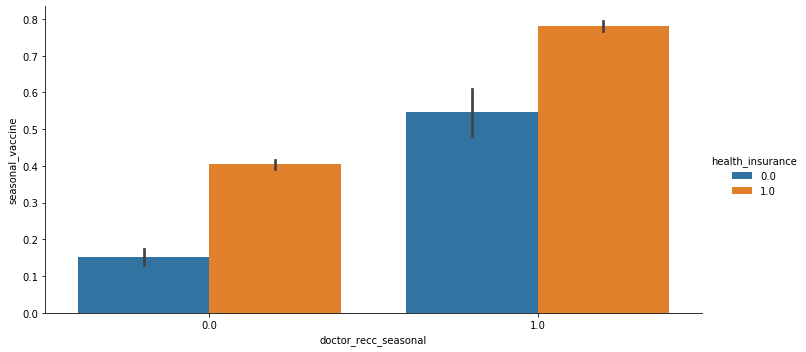

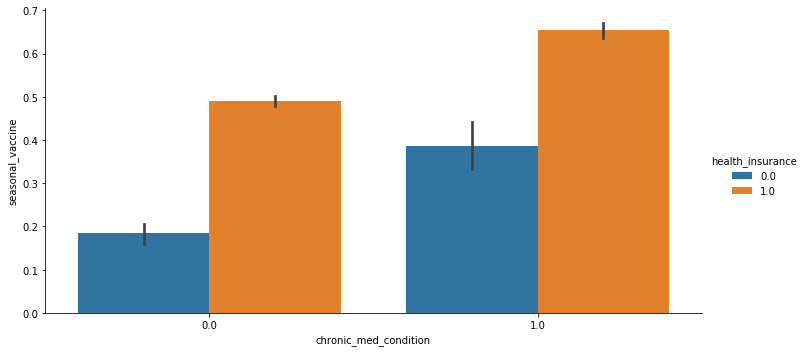

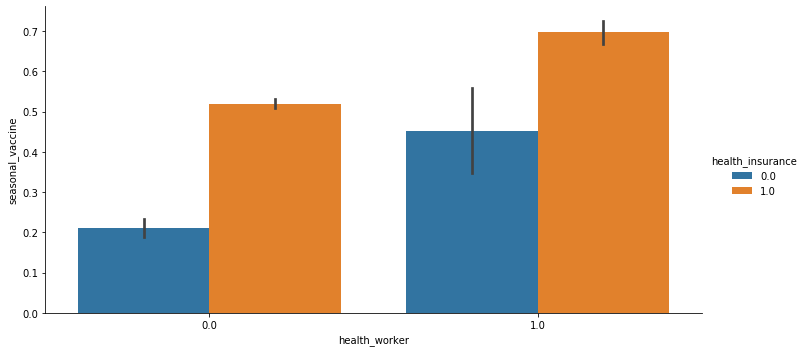

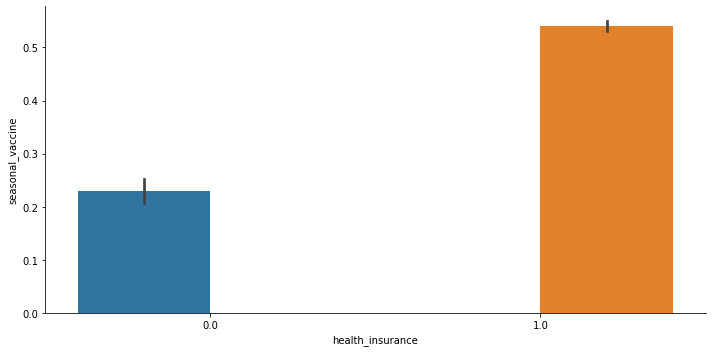

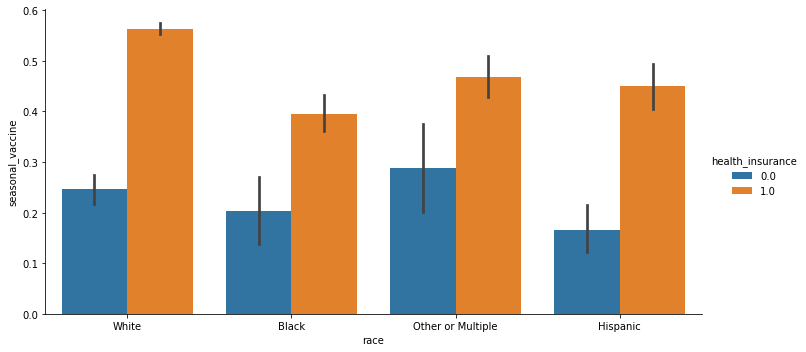

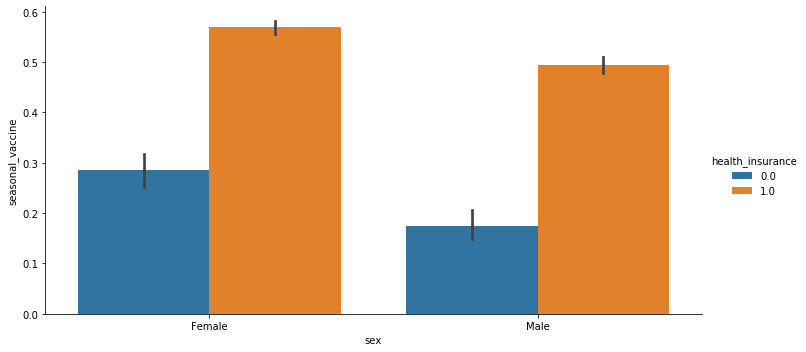

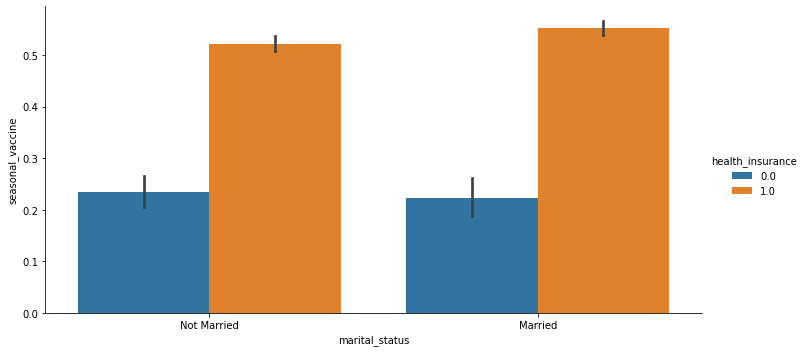

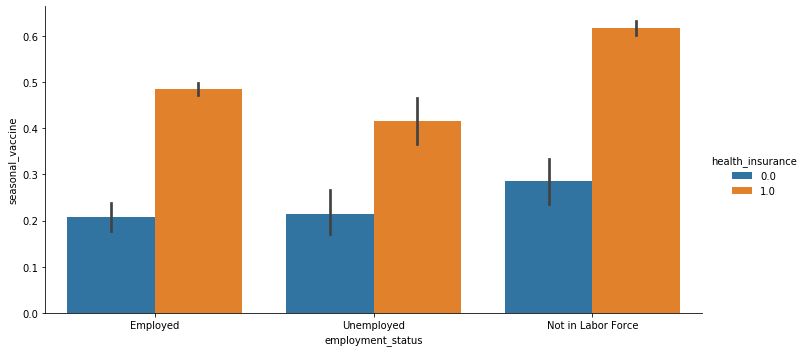

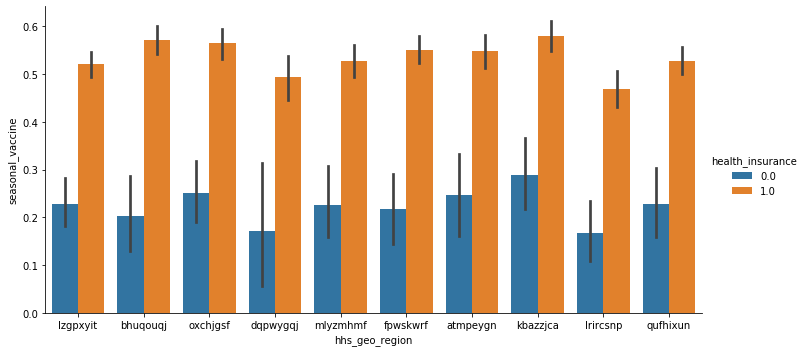

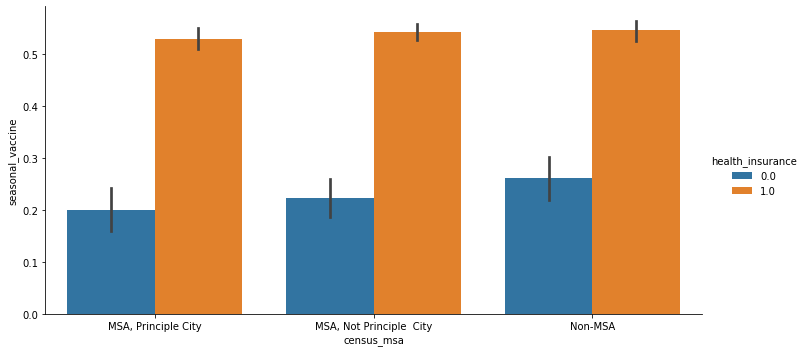

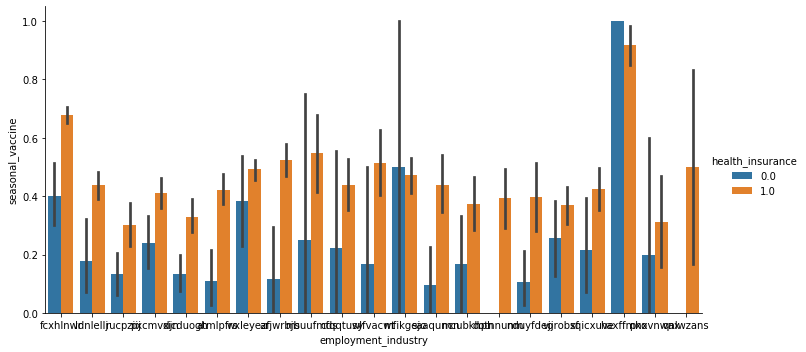

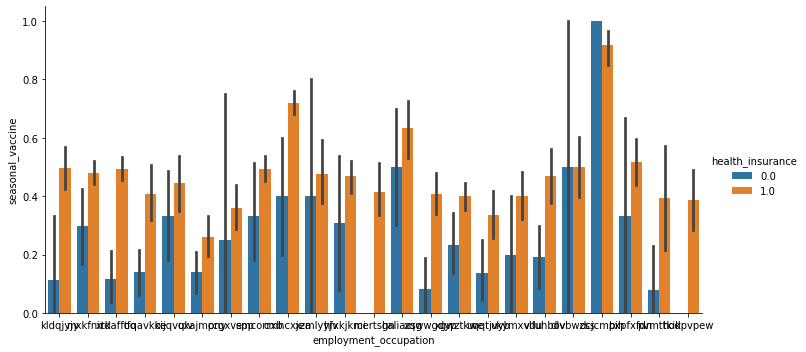

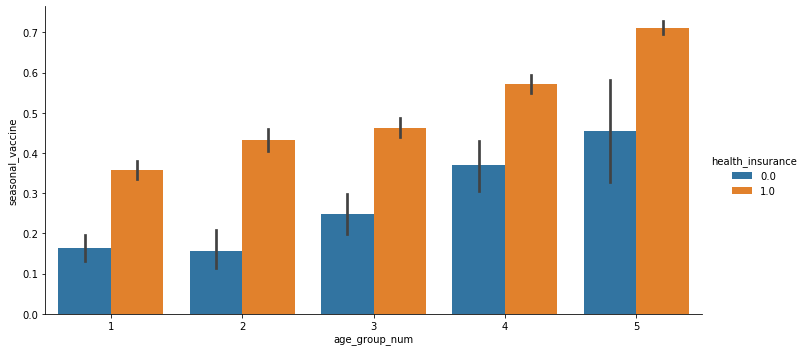

In [50]:
# plot bar graphs for each variable vs target
# test different hues to get sense of variable interactions

for c in train_to_plot.drop(columns=['seasonal_vaccine']).columns:
    sns.catplot(x=c, y="seasonal_vaccine", kind="bar", hue='health_insurance', data=train_to_plot, height=5, aspect=2)
    
# interesting interactions:
# sex and marital status
# census_msa and race (what's going on?)
# sex and race
# also sex and employment status --> probably due to age

### Baseline Model

Please see the [baseline model notebook](https://github.com/lilisbeit/vaccine-learning/blob/main/baseline-model.ipynb) to view the initial logistic regression model I tested.  This model encoded all categorical columns while dropping the first category in each, creating a dataframe of only binary columns.  I then filled all null values with 0.5.  This baseline model produced an **ROC-AUC score of 0.76** on both the training and test sets.

### Model Evaluation

I used an ROC-AUC score, accuracy score, and F1 score to evaluate model performance throughout this project. The model's purpose is to obtain a rough estimate of which patients are less likely to receive the flu vaccine and target them for outreach. There is no need to identify every single patient who did or did not get the vaccine, so these composite scores are better measures than precision or recall.  Accuracy and F1 mostly moved in lockstep with ROC-AUC, and provided equally good measures of performance.

### Feature Engineering

In this section, I tested different ways to engineer the variables to improve model performance.

I grouped together categories in the 'employment_industry' and 'employment_occupation' columns that had similar vaccination outcomes to reduce dimensionality.

I also experimented with dropping all firsts, some firsts, and no firsts when encoding.  Dropping just two firsts slightly improved model performance.

Finally, I filled all null values with 0 and created additional columns to mark whether the original information was null.  This method produced slightly better scores than imputing 0.5 for all nulls.

These three changes improved model performance, producing an **ROC-AUC score of 0.78** for the test and train sets.

I also tested using scalers, adding interaction terms, and changing the parameters of the logistic regression.  None of these changes improved model performance.


**Reduce Number of Columns by Grouping Similar Categories**

['haxffmxo' 'qnlwzans' 'fcxhlnwr' 'arjwrbjb' 'wxleyezf' 'mfikgejo'
 'msuufmds' 'cfqqtusy' 'ldnlellj' 'atmlpfrs' 'dotnnunm' 'pxcmvdjn'
 'wlfvacwt' 'nduyfdeo' 'saaquncn' 'xqicxuve' 'phxvnwax' 'mcubkhph'
 'vjjrobsf' 'xicduogh' 'rucpziij']


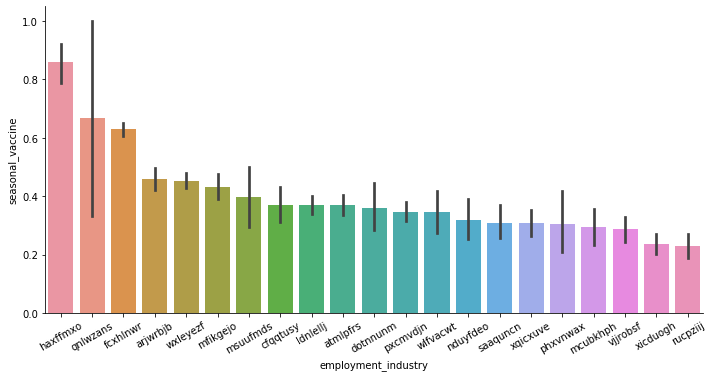

In [19]:
# arrange employment_industry values by probability - see if there are groupings
# reducing number of columns may reduce overfitting and improve the model

sort_order = train_to_plot.groupby('employment_industry')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_industry', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [20]:
# create employment_industry groupings

ind_cat_1 = ['haxffmxo'] # clearly number one
ind_cat_2 = ['fcxhlnwr'] # clearly number two
ind_cat_3 = ['qnlwzans'] # clearly an oddball
ind_cat_4 = ['rucpziij','xicduogh'] # on the bottom
ind_cat_5 = ['msuufmds','arjwrbjb','wxleyezf','mfikgejo','wlfvacwt','phxvnwax','ldnlellj','dotnnunm','atmlpfrs'] # mid upper
ind_cat_6 = ['cfqqtusy','pxcmvdjn','xqicxuve','vjjrobsf','nduyfdeo','mcubkhph','saaquncn'] # mid lower

In [21]:
# create columns for employment_industry categories

ind_cat_list = [ind_cat_1, ind_cat_2, ind_cat_3, ind_cat_4, ind_cat_5, ind_cat_6]

for n, ind_cat in enumerate(ind_cat_list):
    X_train['ind_cat_'+str(n+1)] = X_train['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6
13363,nan,0.00000,1.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
21670,0.00000,0.00000,1.00000,1.00000,35 - 44 Years,White,Female,Not Married,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,cmhcxjea,0,1,0,0,0,0
26509,0.00000,0.00000,0.00000,nan,55 - 64 Years,Other or Multiple,Female,Not Married,Not in Labor Force,fpwskwrf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
26244,0.00000,0.00000,0.00000,nan,18 - 34 Years,White,Female,Married,Not in Labor Force,lrircsnp,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
26626,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,White,Male,Not Married,Employed,oxchjgsf,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,0,0,0,0,1
15728,0.00000,1.00000,0.00000,nan,35 - 44 Years,Hispanic,Female,Married,Not in Labor Force,kbazzjca,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
12316,0.00000,0.00000,0.00000,nan,18 - 34 Years,Black,Female,Not Married,Not in Labor Force,qufhixun,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
15667,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Employed,bhuqouqj,"MSA, Principle City",wlfvacwt,xgwztkwe,0,0,0,0,1,0
5614,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,Hispanic,Female,Not Married,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
5527,1.00000,0.00000,0.00000,1.00000,35 - 44 Years,Hispanic,Female,Not Married,Unemployed,fpwskwrf,Non-MSA,NaN,NaN,0,0,0,0,0,0


['dcjcmpih' 'cmhcxjea' 'haliazsg' 'xzmlyyjv' 'hodpvpew' 'emcorrxb'
 'bxpfxfdn' 'mxkfnird' 'dlvbwzss' 'xtkaffoo' 'hfxkjkmi' 'kldqjyjy'
 'vlluhbov' 'oijqvulv' 'xgwztkwe' 'ccgxvspp' 'xqwwgdyp' 'ukymxvdu'
 'rcertsgn' 'pvmttkik' 'tfqavkke' 'uqqtjvyb' 'qxajmpny']


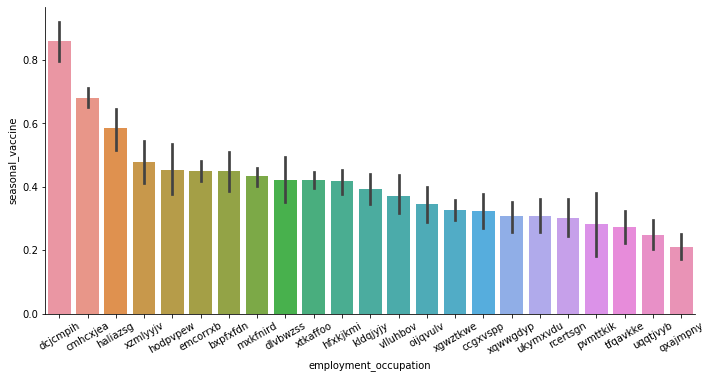

In [22]:
# arrange employment_occupation values by probability - see if there are groupings

sort_order = train_to_plot.groupby('employment_occupation')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_occupation', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [23]:
# create employment_occupation categories

occ_cat_1 = ['dcjcmpih'] # clearly number one
occ_cat_2 = ['cmhcxjea'] # clearly number two
occ_cat_3 = ['haliazsg'] # clearly number three
occ_cat_4 = ['tfqavkke','uqqtjvyb','qxajmpny'] # on the bottom
occ_cat_5 = ['xzmlyyjv', 'hodpvpew', 'emcorrxb','bxpfxfdn', 'mxkfnird', 'xtkaffoo', 'hfxkjkmi', 'dlvbwzss', 'kldqjyjy'] # mid upper
occ_cat_6 = ['vlluhbov','ukymxvdu','oijqvulv','xgwztkwe','rcertsgn','ccgxvspp','pvmttkik', 'xqwwgdyp'] # mid lower

In [24]:
# create categories for employment_occupation to reduce dimensionality

occ_cat_list = [occ_cat_1, occ_cat_2, occ_cat_3, occ_cat_4, occ_cat_5, occ_cat_6]

for n, occ_cat in enumerate(occ_cat_list):
    X_train['occ_cat_'+str(n+1)] = X_train['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6
13363,nan,0.00000,1.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
21670,0.00000,0.00000,1.00000,1.00000,35 - 44 Years,White,Female,Not Married,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,cmhcxjea,0,1,0,0,0,0,0,1,0,0,0,0
26509,0.00000,0.00000,0.00000,nan,55 - 64 Years,Other or Multiple,Female,Not Married,Not in Labor Force,fpwskwrf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
26244,0.00000,0.00000,0.00000,nan,18 - 34 Years,White,Female,Married,Not in Labor Force,lrircsnp,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
26626,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,White,Male,Not Married,Employed,oxchjgsf,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,0,0,0,0,1,0,0,0,0,0,1
15728,0.00000,1.00000,0.00000,nan,35 - 44 Years,Hispanic,Female,Married,Not in Labor Force,kbazzjca,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
12316,0.00000,0.00000,0.00000,nan,18 - 34 Years,Black,Female,Not Married,Not in Labor Force,qufhixun,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
15667,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Employed,bhuqouqj,"MSA, Principle City",wlfvacwt,xgwztkwe,0,0,0,0,1,0,0,0,0,0,0,1
5614,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,Hispanic,Female,Not Married,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
5527,1.00000,0.00000,0.00000,1.00000,35 - 44 Years,Hispanic,Female,Not Married,Unemployed,fpwskwrf,Non-MSA,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# drop old 'employment_industry' and 'employment_occupation' columns

X_train.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Test dropping different first categories when encoding**

In [26]:
# encode remaining categorical columns in X_train
# do not drop all firsts, but drop sex_Female and race_Other to reduce columns

X_train_enc = pd.get_dummies(X_train, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# experimented with dropping all firsts as in baseline model, but produced worse scores

# scores when dropped 1 column - female
# ROC Scores
# Train: 0.7817244813917411
# Test: 0.7748843069535213

# scores when dropped 2 columns - female and other race
# ROC Scores
# Train: 0.7803958619891809
# Test: 0.7782699504901386

# scores when 5 columns dropped
# ROC Scores
# Train: 0.780485435457886
# Test: 0.772152694994743

# stick with dropping 2 columns - female and other race

In [27]:
# 4 binary columns still have nulls
X_train_enc.isna().sum()[:4]

doctor_recc_seasonal     1593
chronic_med_condition     718
health_worker             586
health_insurance         9122
dtype: int64

**Explore the Possibility of Deleting Rows with Nulls**

Conclusion: There are too many null values to delete all rows with nulls, even in any one category.

In [28]:
# calculate what per cent of rows would be deleted if we deleted rows with nulls

# cannot delete rows with missing health_insurance, since about 50%
# check for overlaps in nulls in other 3 rows, may be possible to delete these rows

X_train_delete_nulls = X_train.loc[(X_train['doctor_recc_seasonal'].notnull()
                                      & X_train['chronic_med_condition'].notnull()
                                      & X_train['health_worker'].notnull())]
X_train_delete_nulls

print('If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:')
print('Number of rows deleted:', len(X_train) - len(X_train_delete_nulls))
print('Per cent of rows deleted:', round(((len(X_train) - len(X_train_delete_nulls))/len(X_train)*100),2), '%')

# if we delete all nulls in all 3 columns, we lose 2295 rows, 11% of data
# so let's not delete them
# Instead, fill them with 0s and create columns to indicate if they had nulls
# also tested filling them with the dummy value 0.5, but did not improve model

If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:
Number of rows deleted: 2216
Per cent of rows deleted: 11.06 %


**Create new columns to capture null info, and fill nulls with 0**

This method improves perforance slightly over filling all nulls with a dummy value, as in the baseline model.


In [29]:
# create new columns to capture null info prior to filling nans with 0

X_train_nans=X_train_enc.copy()
X_train_nans['null_doctor_recc'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_chronic'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_worker'] = X_train_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_ins'] = X_train_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans.head(100)

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
13363,nan,0.00000,1.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0
21670,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
26509,0.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
26244,0.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
26626,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
15728,0.00000,1.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
12316,0.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
15667,0.00000,0.00000,0.00000,nan,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5614,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5527,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
# fill nans with 0

X_train_nans.fillna(value=0, inplace=True)
X_train_nans.isna().sum().sum() #0
X_train_nans.shape
X_train_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
13363,0.00000,0.00000,1.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0
21670,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
26509,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
26244,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
26626,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14156,0.00000,0.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2770,0.00000,1.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1
12321,1.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4828,1.00000,1.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


**Create correlation matrix to check for multicolinearity**

No surprising correlations, except maybe ind_cat_1 and occ_cat_1.  Looks like these are exactly the same people.  Also, the same rows have null info for doctor_recc_seasonal and chronic_med_condition.  In next pass, experiment with deleting 1 of each pair.

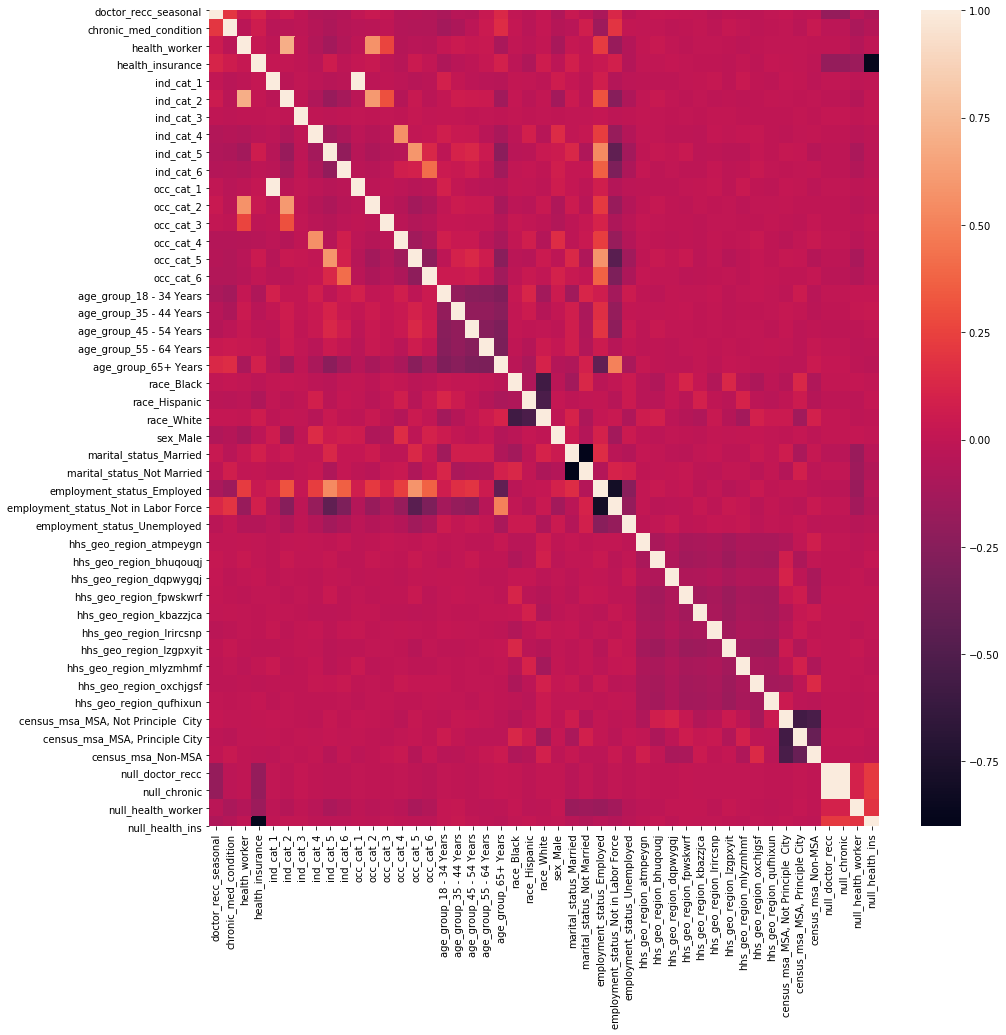

In [31]:
corr = X_train_nans.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, ax=ax);

**Run test set through feature engineering changes and evaluate model**

New **ROC-AUC score is 0.78** for training and test sets.

In [32]:
# run X_test thru same steps

# create categories for employment_industry
for n, ind_cat in enumerate(ind_cat_list):
    X_test['ind_cat_'+str(n+1)] = X_test['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)

# create categories for employment_industry
for n, occ_cat in enumerate(occ_cat_list):
    X_test['occ_cat_'+str(n+1)] = X_test['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)

X_test.drop(columns=['employment_industry','employment_occupation'], inplace=True)

# encode categorical columns
X_test_enc = pd.get_dummies(X_test, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# create columns to track null values
X_test_nans=X_test_enc.copy()
X_test_nans['null_doctor_recc'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_chronic'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_worker'] = X_test_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_ins'] = X_test_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)

# fill remaining nulls with 0
X_test_nans.fillna(value=0, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pan

In [33]:
X_test_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
20071,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23513,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
23860,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
19890,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
24073,1.00000,0.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
18981,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
251,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
21967,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


ROC Scores
Train: 0.7800982122278006
Test: 0.7752341237571112


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626


Cross-Validation Scores:
Train:
[0.77078774 0.77133752 0.79190504 0.78177705 0.77364088]
Mean: 0.778
Test:
[0.77473608 0.77973784 0.76710797 0.78860302 0.76870061]
Mean: 0.776


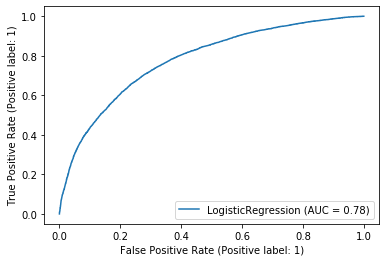

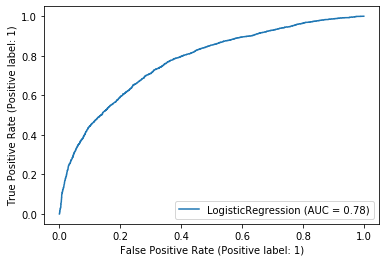

In [34]:
# plot ROC curves
logreg = ut.logreg_predict_score(X_train_nans, X_test_nans, y_train, y_test)
plot_roc_curve(logreg, X_train_nans, y_train)
plot_roc_curve(logreg, X_test_nans, y_test)


**Test Standard Scaler**

In [35]:
# Let's scale it!  # test Standard Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

In [36]:
ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale
# only F1 scores are better for standard scaler.  Why?  Test on next pass

ROC Scores
Train: 0.7801322740983475
Test: 0.7753669567378743


Accuracy Scores
Train: 0.7142286570144782
Test: 0.7072038340572113


F1 Scores
Train: 0.6939037433155081
Test: 0.687849273511097


Cross-Validation Scores:
Train:
[0.77096787 0.77125334 0.79186797 0.78201505 0.77363236]
Mean: 0.778
Test:
[0.77520172 0.77972435 0.76711247 0.78889587 0.76858572]
Mean: 0.776


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test MinMax Scaler**

In [37]:
# Let's scale it!  # test MixMax Scaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7800982122278006
Test: 0.7752341237571112


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626


Cross-Validation Scores:
Train:
[0.77078774 0.77133752 0.79190504 0.78177705 0.77364088]
Mean: 0.778
Test:
[0.77473608 0.77973784 0.76710797 0.78860302 0.76870061]
Mean: 0.776


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test Interaction Term for 'male' and 'married'**

In [38]:
# add interaction term for man & married

X_train_inter = X_train_nans.copy()
X_train_inter['man_Married'] = X_train_inter['sex_Male'] * X_train_inter['marital_status_Married']
X_train_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
13363,0.00000,0.00000,1.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0
21670,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
26509,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
26244,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
26626,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14156,0.00000,0.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2770,0.00000,1.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
12321,1.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4828,1.00000,1.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1


In [39]:
# do same steps on X_test
X_test_inter = X_test_nans.copy()
X_test_inter['man_Married'] = X_test_inter['sex_Male'] * X_test_inter['marital_status_Married']
X_test_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
20071,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
23513,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
23860,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
19890,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
24073,1.00000,0.00000,1.00000,0.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
18981,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
251,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
21967,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [40]:
# test version with interaction term

ut.logreg_predict_score(X_train_inter, X_test_inter, y_train, y_test)

# no change

ROC Scores
Train: 0.7801143061860525
Test: 0.7751906265844273


Accuracy Scores
Train: 0.7142286570144782
Test: 0.7040587090010484


F1 Scores
Train: 0.6801162400804739
Test: 0.6687898089171975


Cross-Validation Scores:
Train:
[0.77077847 0.77134504 0.79193436 0.78181137 0.77356272]
Mean: 0.778
Test:
[0.77476307 0.77960512 0.76705841 0.788166   0.76789866]
Mean: 0.775


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test LogisticRegression() parameters**

ROC Scores
Train: 0.7800985830101513
Test: 0.7752339436445946


Accuracy Scores
Train: 0.7141787319021468
Test: 0.704358244720683


F1 Scores
Train: 0.6801139855841761
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


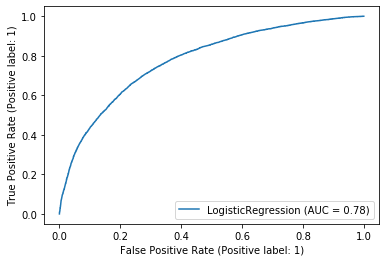

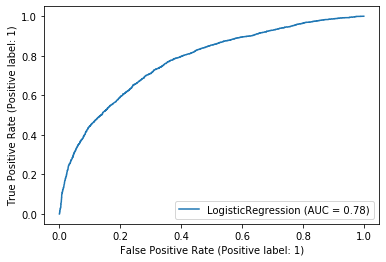

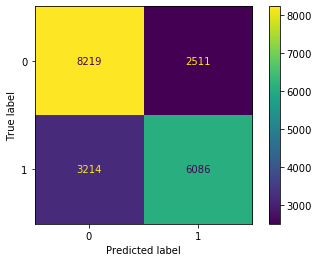

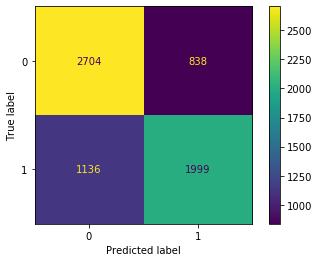

In [41]:
# test fit_intercept=True

# make logistic regression
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')
logreg.fit(X_train_nans, y_train)

# print ROC scores
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)

# no change

LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7801024010662497
Test: 0.7752316922381411


Accuracy Scores
Train: 0.7141787319021468
Test: 0.704358244720683


F1 Scores
Train: 0.6800782341436155
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7800986130735852
Test: 0.7752369155011134


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7800990239405146
Test: 0.7752358348260158


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test 

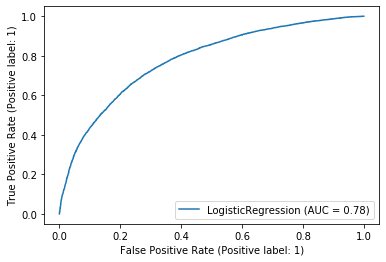

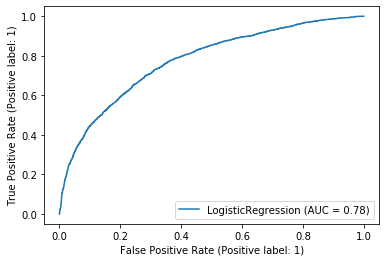

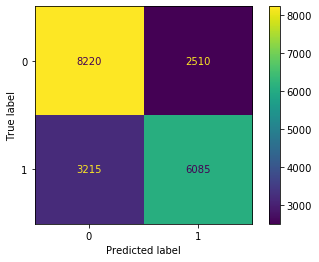

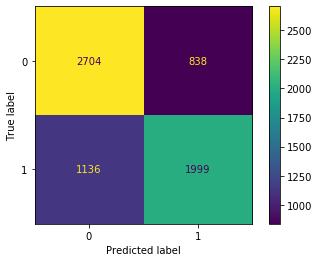

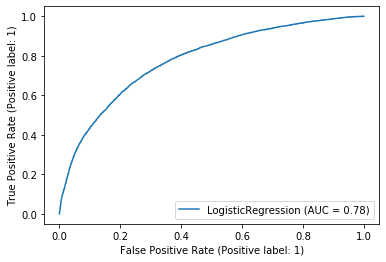

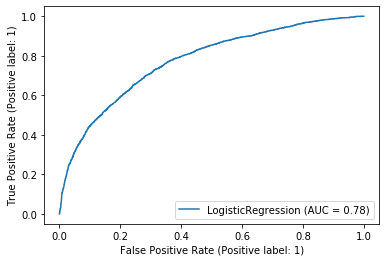

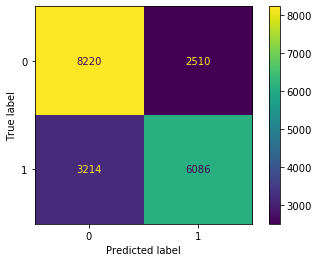

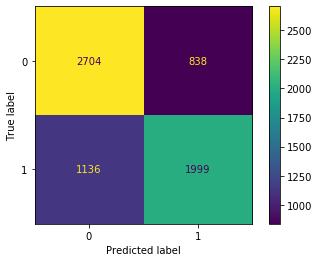

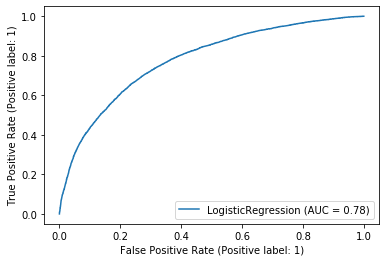

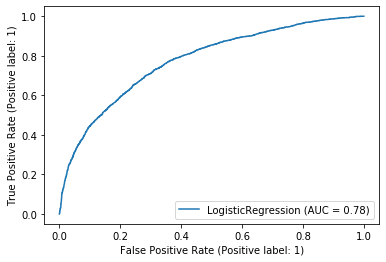

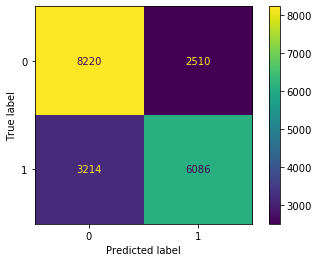

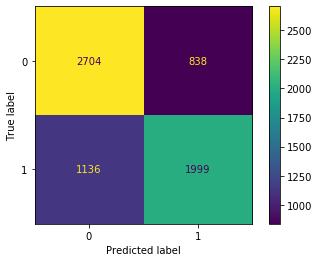

In [42]:
# test C

c_list = [10,100,1000]

# make logreg and score
for c in c_list:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    logreg.fit(X_train_nans, y_train)
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
# no change

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='newton-cg')
ROC Scores
Train: 0.7800979015723175
Test: 0.7752363751635647


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:




/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegression(C=1000000000000.0, fit_intercept=False)
ROC Scores
Train: 0.7800953862650193
Test: 0.7752833845303162


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6695681285570807
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7800982122278006
Test: 0.7752341237571112


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='sag')
ROC Scores
Train: 0.7800990740462376
Test: 0.7752370956136299


Accuracy Scores
Train: 0.7142286570144782
Test: 0.704358244720683


F1 Scores
Train: 0.6801519892713456
Test: 0.6694574681848626
Train ROC Curve
Test ROC Curve
Train Confusion Mat

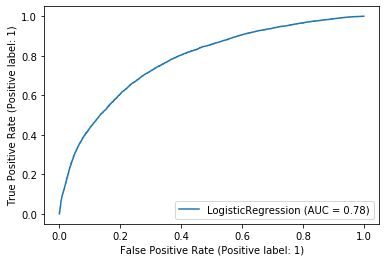

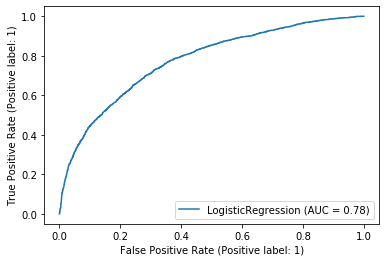

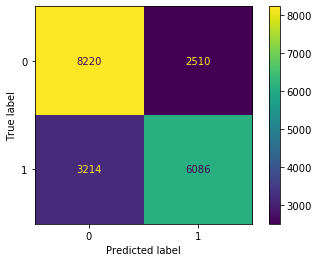

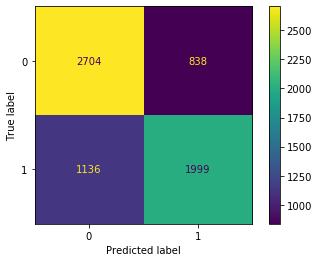

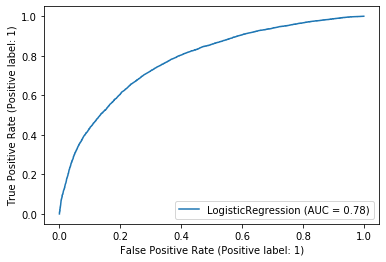

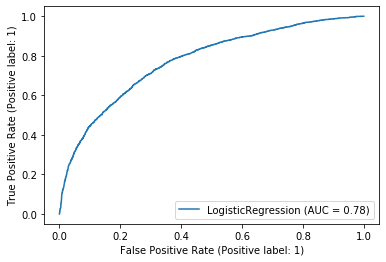

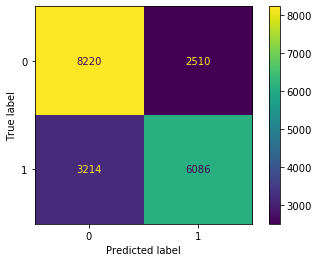

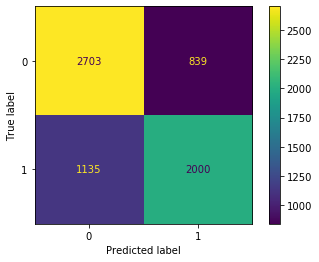

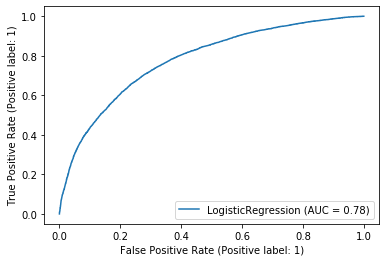

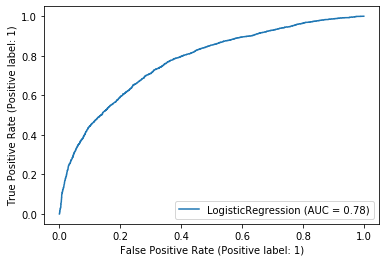

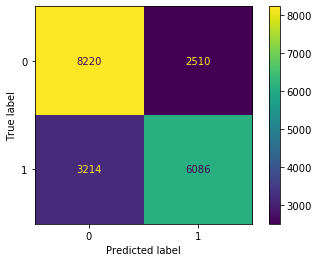

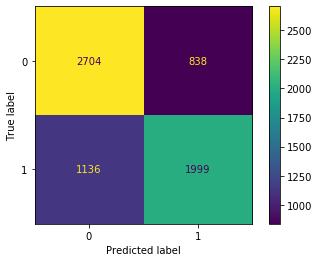

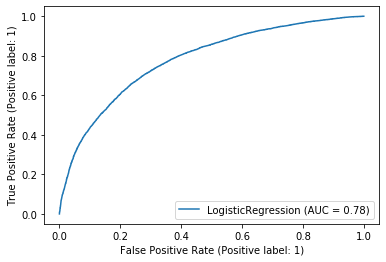

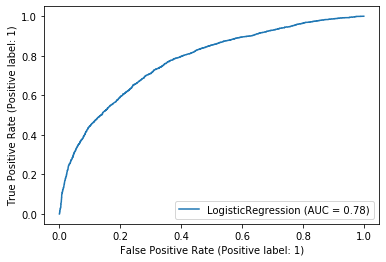

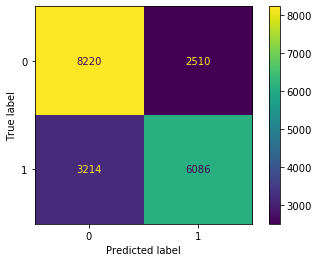

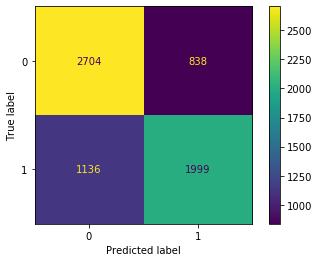

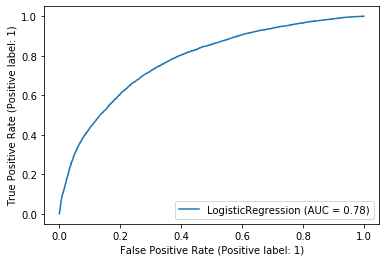

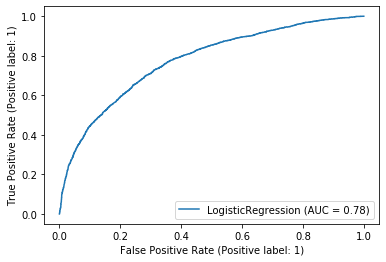

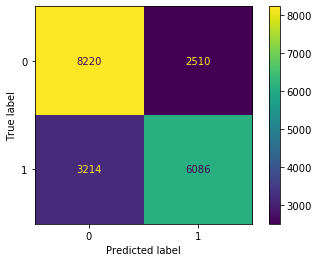

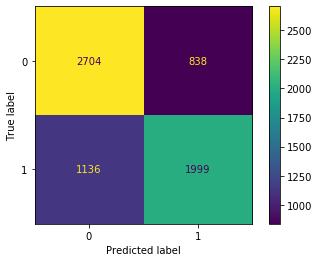

In [43]:
# test solvers

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver=s)
    logreg.fit(X_train_nans, y_train)
    # score
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
    # no change

In [44]:
# no change when using different scalers, adding interaction terms, or changing logreg parameters
# stick with inital df (X_train_nans)
# stick with initial parameters for logreg

best_logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
best_logreg.fit(X_train_nans, y_train)


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

### Check Coefficient Weights

In [45]:
# check out coefficients

top_ten = ut.order_features(best_logreg.coef_[0], X_train_nans)[:10]
top_ten

,weight,abs_weight
ind_cat_3,1.81140,1.81140
ind_cat_1,1.50420,1.50420
occ_cat_1,1.50420,1.50420
doctor_recc_seasonal,1.49350,1.49350
age_group_18 - 34 Years,-0.93900,0.93900
health_worker,0.68070,0.68070
age_group_35 - 44 Years,-0.66120,0.66120
health_insurance,0.65440,0.65440
census_msa_Non-MSA,-0.63820,0.63820
race_Black,-0.53750,0.53750


In [46]:
# run lists below to be sure my coefficients are linking up to the right column labels
# they are

tuple_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, best_logreg.coef_[0][n])
    tuple_list.append(tuple)
    
tuple_list

[(0, 1.4934752153653035),
 (1, 0.3743564739288938),
 (2, 0.6807001751780196),
 (3, 0.6544054950044224),
 (4, 1.5042054877905464),
 (5, 0.5307445900298668),
 (6, 1.811387573350434),
 (7, -0.08489150798998205),
 (8, 0.35130702465837094),
 (9, 0.06677401278924003),
 (10, 1.5042054877905464),
 (11, 0.20584422948700257),
 (12, 0.0014698441034355324),
 (13, -0.3895725917491686),
 (14, -0.0603017836429533),
 (15, -0.33137434420919226),
 (16, -0.9390177008089475),
 (17, -0.6611567034645658),
 (18, -0.4795683817249847),
 (19, -0.12738910299085882),
 (20, 0.5313419107900172),
 (21, -0.5374839459283667),
 (22, -0.07845964015474637),
 (23, 0.08304315835753498),
 (24, -0.1017403509539224),
 (25, 0.03947037473018694),
 (26, -0.14831334628304638),
 (27, -0.37363774963618734),
 (28, -0.18829552743361275),
 (29, -0.4671453194704738),
 (30, -0.059407028852180986),
 (31, -0.10278138902027241),
 (32, -0.3267418221650372),
 (33, -0.12296787000978943),
 (34, -0.11413603564841293),
 (35, -0.32675731764773447

In [47]:
col_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, X_train_nans.columns[n])
    col_list.append(tuple)
    
col_list

[(0, 'doctor_recc_seasonal'),
 (1, 'chronic_med_condition'),
 (2, 'health_worker'),
 (3, 'health_insurance'),
 (4, 'ind_cat_1'),
 (5, 'ind_cat_2'),
 (6, 'ind_cat_3'),
 (7, 'ind_cat_4'),
 (8, 'ind_cat_5'),
 (9, 'ind_cat_6'),
 (10, 'occ_cat_1'),
 (11, 'occ_cat_2'),
 (12, 'occ_cat_3'),
 (13, 'occ_cat_4'),
 (14, 'occ_cat_5'),
 (15, 'occ_cat_6'),
 (16, 'age_group_18 - 34 Years'),
 (17, 'age_group_35 - 44 Years'),
 (18, 'age_group_45 - 54 Years'),
 (19, 'age_group_55 - 64 Years'),
 (20, 'age_group_65+ Years'),
 (21, 'race_Black'),
 (22, 'race_Hispanic'),
 (23, 'race_White'),
 (24, 'sex_Male'),
 (25, 'marital_status_Married'),
 (26, 'marital_status_Not Married'),
 (27, 'employment_status_Employed'),
 (28, 'employment_status_Not in Labor Force'),
 (29, 'employment_status_Unemployed'),
 (30, 'hhs_geo_region_atmpeygn'),
 (31, 'hhs_geo_region_bhuqouqj'),
 (32, 'hhs_geo_region_dqpwygqj'),
 (33, 'hhs_geo_region_fpwskwrf'),
 (34, 'hhs_geo_region_kbazzjca'),
 (35, 'hhs_geo_region_lrircsnp'),
 (36, 'h

In [48]:
# run permutation importance to confirm feature importance

r = permutation_importance(best_logreg, X_test_nans, y_test, n_repeats=30)

In [49]:
top_ten = ut.order_features(r['importances'][:,0], X_train_nans)[:10]
top_ten

,weight,abs_weight
doctor_recc_seasonal,0.09030,0.09030
age_group_65+ Years,0.01000,0.01000
age_group_18 - 34 Years,0.00880,0.00880
census_msa_Non-MSA,0.00850,0.00850
age_group_35 - 44 Years,0.00750,0.00750
employment_status_Employed,0.00550,0.00550
null_health_ins,0.00490,0.00490
"census_msa_MSA, Not Principle City",0.00480,0.00480
"census_msa_MSA, Principle City",0.00360,0.00360
health_worker,0.00300,0.00300


### Create plots for presentation to showcase influential variables

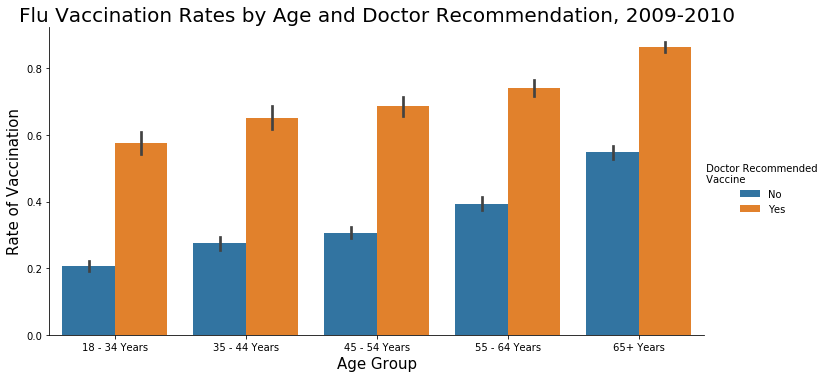

In [57]:
# create a plot to show importance of doctor recommendation

# create new df for plotting age
age_plot = pd.concat([X_train, y_train], axis=1)

# sort age categories appropriately for plotting
sort_order = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']

ax = sns.catplot(data=age_plot, x='age_group', y='seasonal_vaccine', hue='doctor_recc_seasonal', kind='bar', height=5, aspect=2, order=sort_order)
plt.title('Flu Vaccination Rates by Age and Doctor Recommendation, 2009-2010', fontsize=20)
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Doctor Recommended \n Vaccine'
ax._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l);
plt.savefig('images/doc_rec.png')

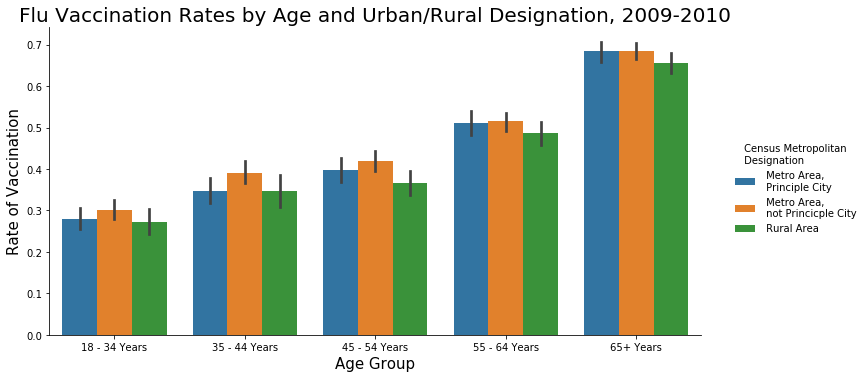

In [56]:
# create a plot to show importance of urban/rural designation

# sort age categories appropriately for plotting
sort_order = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']

ax = sns.catplot(data=age_plot, x='age_group', y='seasonal_vaccine', hue='census_msa', kind='bar', height=5, aspect=2, order=sort_order)
plt.title('Flu Vaccination Rates by Age and Urban/Rural Designation, 2009-2010', fontsize=20)
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Census Metropolitan \n Designation'
ax._legend.set_title(new_title)
# replace labels
new_labels = [' Metro Area, \n Principle City', ' Metro Area, \n not Princicple City', ' Rural Area']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l);
plt.savefig('images/msa.png')


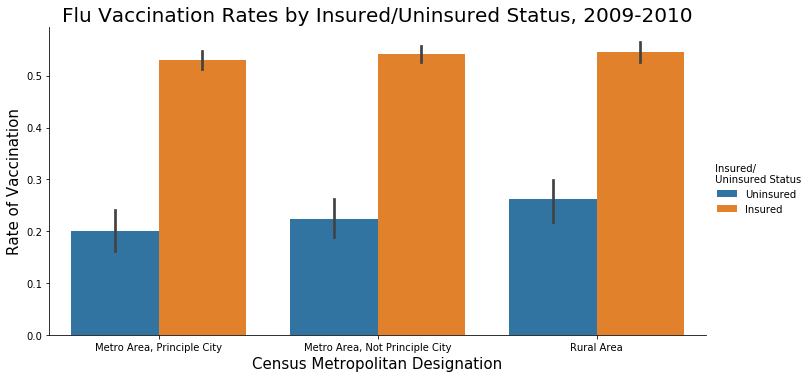

In [66]:
# create a plot to show importance of health insurance

ax = sns.catplot(data=age_plot, x='census_msa', y='seasonal_vaccine', hue='health_insurance', kind='bar', height=5, aspect=2)
plt.title('Flu Vaccination Rates by Insured/Uninsured Status, 2009-2010', fontsize=20)
plt.xlabel('Census Metropolitan Designation', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Insured/ \n Uninsured Status'
ax._legend.set_title(new_title)
# replace legend labels
new_labels = ['Uninsured', 'Insured']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)
# replace xtick labels
ax.set_xticklabels(['Metro Area, Principle City', 'Metro Area, Not Principle City', 'Rural Area'])
plt.savefig('images/insurance.png')

## Test Additional Models

In this section I tested a Decision Tree model, a bagged Decision Tree, a Random Forest, an XGBoost model using the 'gbtree' booster, an XGBoost model using the 'dart' booster, and a Support Vector Machine.  None improved on the performance of the Logistic Regression model (ROC-AUC 0.78 for both train and test).  The models produced the following ROC-AUC scores:

* Decision Tree: 0.77 for train, 0.76 for test
* Bagged Decision Tree: 0.77 for train, 0.76 for test
* Random Forest: 0.77 for both train and test
* XGBoost gbtree: 0.82 for train, 0.78 for test
* XGBoost dart: 0.82 for train, 0.77 for test
* Support Vector Machine: 0.77 for both train and test

I chose to test tree-based models because the bar graphs above show many interactions among the features, and decision trees handle interactions well.  When my initial decision tree did not produce superior results, I tried the other tree methods to see if they performed better.  They did, but never outperformed the Logistic Regression.  Since the gradient-boosted models were overfit, I then tested a Support Vector Machine, which also did not outperform the Logistic Regression.

### Decision Tree

ROC Scores
Train: 0.9829650713004439
Test: 0.6288847342935132


Accuracy Scores
Train: 0.9133799301048428
Test: 0.6200389396435525


F1 Scores
Train: 0.9032617786451073
Test: 0.5815602836879433
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


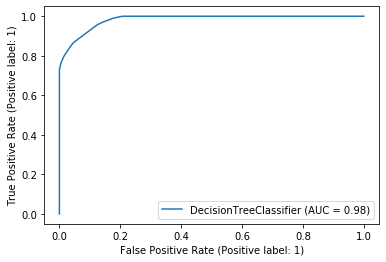

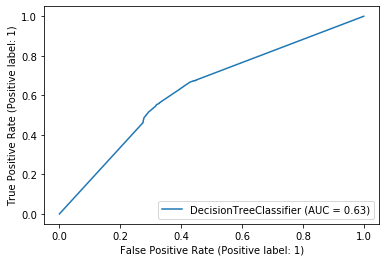

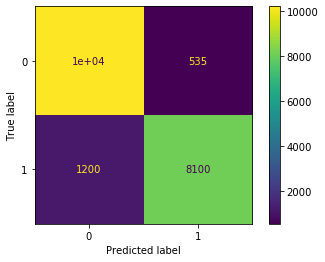

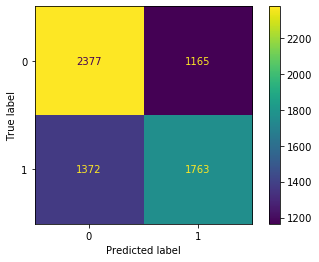

In [50]:
# let's do another model!

tree = DecisionTreeClassifier()

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# yikes, that's really overfit!  let's prune the tree

ROC Scores
Train: 0.7715846435979917
Test: 0.7631437108761843


Accuracy Scores
Train: 0.7131802296555168
Test: 0.7040587090010484


F1 Scores
Train: 0.6865964759151165
Test: 0.6770186335403726
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


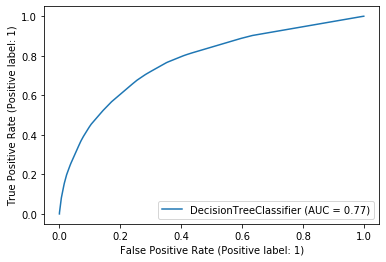

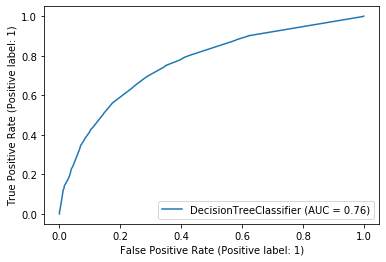

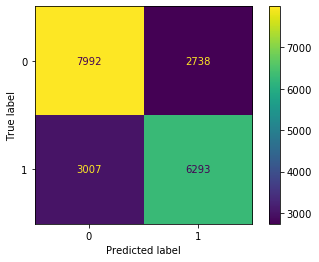

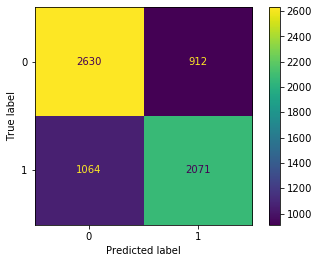

In [51]:
# tune tree parameters to reduce overfitting

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, max_features=40, criterion='gini')

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# better, but not better than logreg

In [52]:
# although a tree is not the final model, check feature importances

tree.feature_importances_

array([5.63864384e-01, 1.23570502e-02, 8.21564853e-02, 1.42481028e-02,
       2.53162656e-02, 9.21676744e-03, 0.00000000e+00, 0.00000000e+00,
       1.46015117e-02, 3.75032632e-03, 0.00000000e+00, 6.99896189e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51003111e-03,
       1.10390151e-02, 1.18597055e-03, 0.00000000e+00, 3.42438423e-02,
       1.76991181e-01, 1.38060862e-02, 0.00000000e+00, 4.47460175e-03,
       0.00000000e+00, 2.74032760e-03, 2.53169208e-03, 2.03727387e-03,
       1.91425124e-03, 1.96358244e-03, 1.46794184e-03, 5.16346734e-04,
       1.90968318e-03, 1.40466517e-03, 0.00000000e+00, 5.61747549e-04,
       2.61360097e-03, 0.00000000e+00, 8.89484920e-04, 0.00000000e+00,
       7.20760484e-04, 4.39305533e-04, 1.04262162e-03, 0.00000000e+00,
       1.48613193e-03, 0.00000000e+00, 0.00000000e+00])

In [53]:
ut.order_features(tree.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.56390,0.56390
age_group_65+ Years,0.17700,0.17700
health_worker,0.08220,0.08220
age_group_55 - 64 Years,0.03420,0.03420
ind_cat_1,0.02530,0.02530
ind_cat_5,0.01460,0.01460
health_insurance,0.01420,0.01420
race_Black,0.01380,0.01380
chronic_med_condition,0.01240,0.01240
age_group_18 - 34 Years,0.01100,0.01100


### Tree with grid search

In [54]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [30, 37, 45]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)
tree_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {tree_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {tree_grid_search.best_params_}")

Training Accuracy: 70.68%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 37, 'min_samples_leaf': 14, 'min_samples_split': 10}


ROC Scores
Train: 0.7685405255088237
Test: 0.7631647390124612


Accuracy Scores
Train: 0.7125312031952072
Test: 0.7055563875992212


F1 Scores
Train: 0.6941463932858812
Test: 0.6857416879795396
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


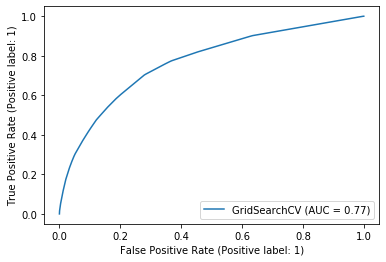

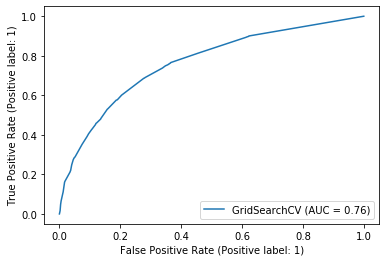

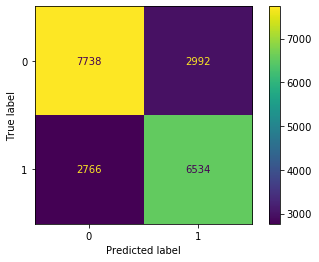

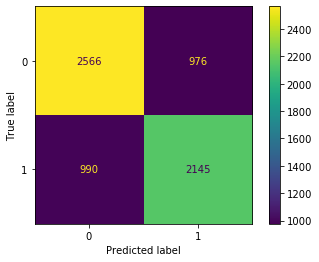

In [55]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree_grid_search)

In [56]:
# check grid search tree features importances

tree_grid_search.best_estimator_.feature_importances_

array([4.68659275e-01, 2.06690062e-02, 1.85994495e-02, 1.34940297e-02,
       0.00000000e+00, 8.98671211e-02, 0.00000000e+00, 0.00000000e+00,
       1.72725658e-02, 2.55814571e-03, 2.42748570e-02, 5.39881730e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.45649147e-03, 0.00000000e+00, 0.00000000e+00, 3.82517350e-02,
       2.52758160e-01, 1.53142202e-02, 0.00000000e+00, 1.00958581e-02,
       8.14313511e-04, 8.03493554e-04, 2.83075236e-03, 5.68997912e-04,
       0.00000000e+00, 1.33696678e-03, 0.00000000e+00, 3.49651453e-04,
       0.00000000e+00, 0.00000000e+00, 3.67714891e-04, 0.00000000e+00,
       2.53023307e-03, 5.10755701e-04, 0.00000000e+00, 1.93038056e-03,
       1.98313892e-04, 0.00000000e+00, 7.20199760e-04, 0.00000000e+00,
       5.08514937e-04, 2.31083106e-04, 6.62889637e-03])

In [57]:
# doctor_recc_seasonal, age groups, and health_insurance still near the top

ut.order_features(tree_grid_search.best_estimator_.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.46870,0.46870
age_group_65+ Years,0.25280,0.25280
ind_cat_2,0.08990,0.08990
age_group_55 - 64 Years,0.03830,0.03830
occ_cat_1,0.02430,0.02430
chronic_med_condition,0.02070,0.02070
health_worker,0.01860,0.01860
ind_cat_5,0.01730,0.01730
race_Black,0.01530,0.01530
health_insurance,0.01350,0.01350


### Bagged Decision Tree

In [58]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
bagged_tree.fit(X_train_nans, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

ROC Scores
Train: 0.7751505877401318
Test: 0.7674462386652943


Accuracy Scores
Train: 0.7112830753869196
Test: 0.7070540661973941


F1 Scores
Train: 0.6951663064677667
Test: 0.6900158478605388
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


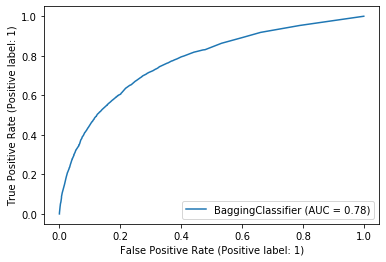

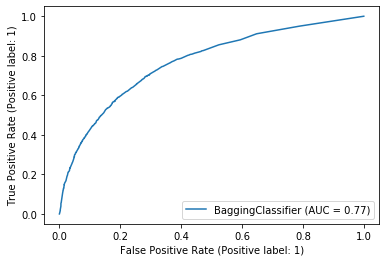

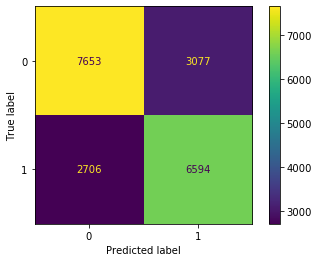

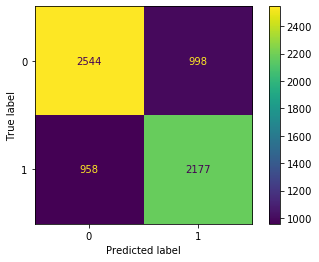

In [59]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, bagged_tree)

# not better than logreg

### Random Forest

In [60]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train_nans, y_train)

RandomForestClassifier(max_depth=5)

ROC Scores
Train: 0.7764866067402219
Test: 0.768644887461197


Accuracy Scores
Train: 0.708537194208687
Test: 0.7010633518047027


F1 Scores
Train: 0.6715057393652936
Test: 0.6631792102598718
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


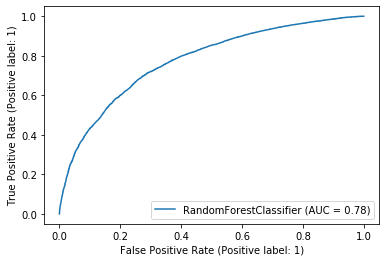

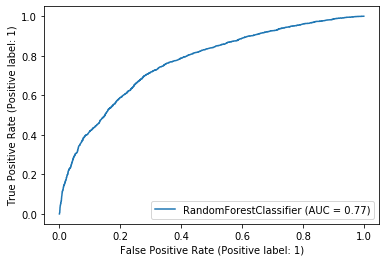

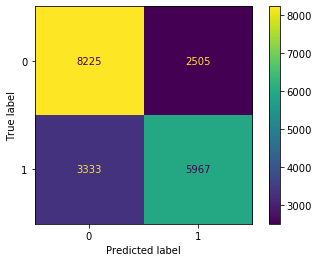

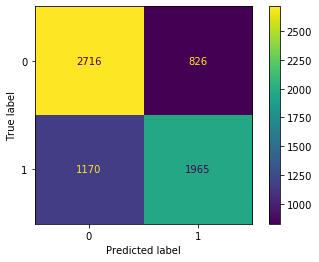

In [61]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, forest)

# no change.  Try grid search with random forest.

In [62]:
rf_param_grid = {'n_estimators': [50, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [6, 10, 14],
                 'min_samples_leaf': [3, 6, 9],
                'min_samples_split': [5, 10, 15]}
                 
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")



Training Accuracy: 71.08%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 100}


ROC Scores
Train: 0.7807325055867881
Test: 0.7710995508894406


Accuracy Scores
Train: 0.7161757363954069
Test: 0.7045080125805002


F1 Scores
Train: 0.6816731059969763
Test: 0.6684590825071416
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


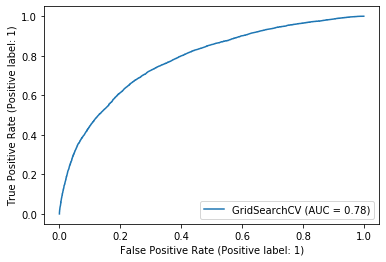

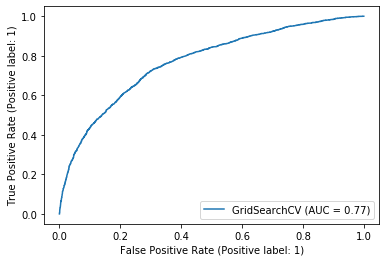

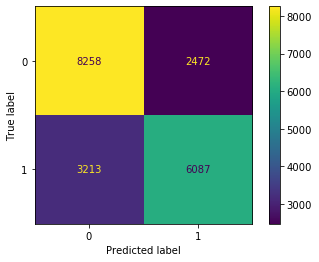

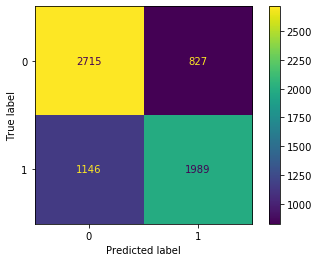

In [63]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, rf_grid_search)

# overfit, test set not better than logreg

### XGBoost Tree

In [64]:
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train_nans, y_train)


XGBClassifier()

ROC Scores
Train: 0.7862220134483762
Test: 0.7762099283422355


Accuracy Scores
Train: 0.717174238642037
Test: 0.7098996555339224


F1 Scores
Train: 0.6860278224242089
Test: 0.6789325377092656
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


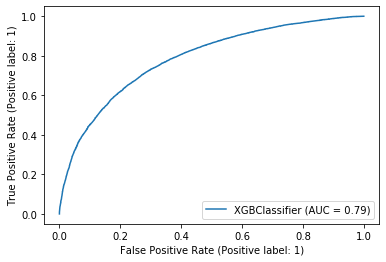

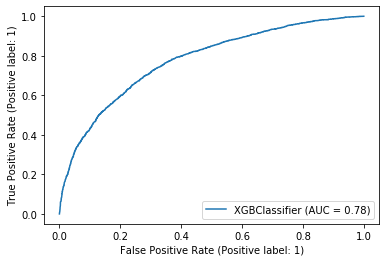

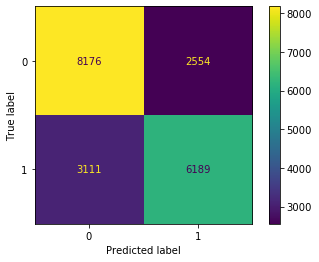

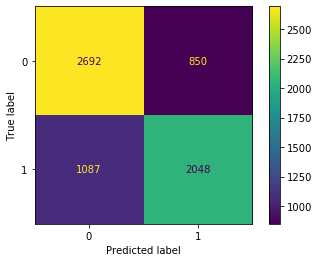

In [65]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, XGB)
# less overfit
# similar to logreg

### XGBoost Tree with Grid Search

In [66]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]}

In [67]:
grid_XGB = GridSearchCV(XGB, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB.fit(X_train_nans, y_train)


GridSearchCV(estimator=XGBClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [6, 8],
                         'min_child_weight': [1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]})

ROC Scores
Train: 0.8165706190061028
Test: 0.771413261864687


Accuracy Scores
Train: 0.7406390414378432
Test: 0.7025610304028755


F1 Scores
Train: 0.7113407790187254
Test: 0.6691102965678107
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


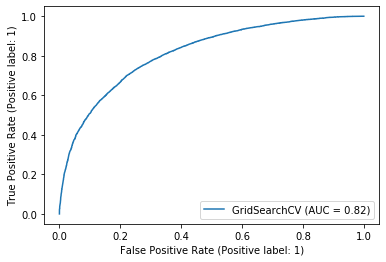

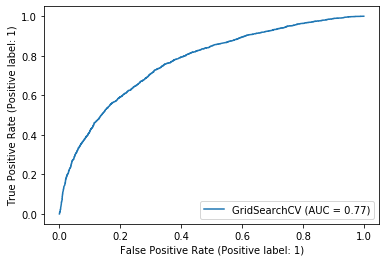

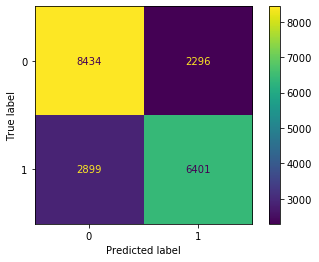

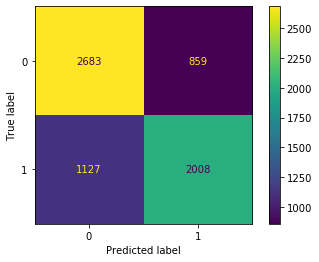

In [68]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB)
# overfit
# not better... try different parameters?

### XGBoost Tree with Dart Booster and Grid Search

In [71]:
XGB_dart = XGBClassifier(booster='dart')

# Fit XGBClassifier dart
XGB_dart.fit(X_train_nans, y_train)

XGBClassifier(booster='dart')

In [72]:
grid_XGB_dart = GridSearchCV(XGB_dart, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB_dart.fit(X_train_nans, y_train)

GridSearchCV(estimator=XGBClassifier(booster='dart'), n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [6, 8],
                         'min_child_weight': [1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]})

In [67]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB_dart)
# not better than logreg

NameError: name 'X_train_nans' is not defined

### Support Vector Machine

In [69]:
SVM = SVC(kernel='linear')
SVM.fit(X_train_nans, y_train)

SVC(kernel='linear')

In [70]:
y_train_pred = SVM.predict(X_train_nans)
y_test_pred = SVM.predict(X_test_nans)

print('ROC Scores')
print('Train:', roc_auc_score(y_train, SVM.decision_function(X_train_nans)))
print('Test:', roc_auc_score(y_test, SVM.decision_function(X_test_nans)))
print('\n')
print('Accuracy Scores')
print('Train:', accuracy_score(y_train, y_train_pred))
print('Test:', accuracy_score(y_test, y_test_pred))
print('\n')
print('F1 Scores')
print('Train:', f1_score(y_train, y_train_pred))
print('Test:', f1_score(y_test, y_test_pred))

# worse scores

ROC Scores
Train: 0.7705481816633096
Test: 0.7656464643462773


Accuracy Scores
Train: 0.6869196205691462
Test: 0.6872847087015127


F1 Scores
Train: 0.6088204104547439
Test: 0.6098654708520179


## Conclusion

### Recommendations

All the models rank the 'doctor_recc_seasonal' variable as the most important feature influencing vaccination.  This suggests that reaching out to patients who have not had a doctor visit during flu season may improve vaccination rates.  It also implies that patients trust their doctors and respond well to their advice.

All models also rank the health insurance and 'census_msa_Non-MSA' features in the top ten.  The latter is a [census designation](https://www.census.gov/programs-surveys/metro-micro/about.html#:~:text=Delineating%20Metropolitan%20and%20Micropolitan%20Statistical%20Areas,-The%202010%20standards&text=Each%20metropolitan%20statistical%20area%20must,but%20less%20than%2050%2C000%20population.) meaning the respondent does not live in a metropolitan area.  The interaction between these variables is complicated, as lower vaccination rates in rural areas seem to be linked to the uninsured population there.  Lovelace should prioritize their uninsured population for outreach, with a secondary focus on rural patients in general.  

Finally, it appears that young people are less likely to get the flu vaccine, and that Lovelace should target 18-34-year-olds if they want to boost population immunity.

### Future Work

Much work remains to paint a clearer picture of which patients are unlikely to get the flu vaccine.  It would be helpful to have data that is more representative of all demographic groups.

There are also many ways experiment with making the model more sophisticated.  Removing features which influence each other (such as rural and uninsured) may clarify which other features are important.  Also, a few geographic and occupational categories have very low values, and eliminating these categories altogether may improve the model.  Finally, It may be worthwhile to try deleting rows with null values to see if that sharpens the model.  